# ResNet Model Evaluation


The trained baseline and dropout ResNet models are evaluated by doing inference on the test split of cross-datasets. To evaluate the application of Monte Carlo Dropout technique, each dropout model also does the inference with 50 Monte Carlo samples. The considered sample value is chosen based on the basic CNN Monte Carlo Sample experiments that resulted no significant performance aligning with the increasing Monte Carlo Sample that requires more computational cost. Each model's performance is interpreted by its ROC curve and AUC values.


In [1]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import display
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import os

%matplotlib inline

## Define Dataset Directory


In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2/Test"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0/Test"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC/Test"

## Define Trained Models Path


In [3]:
RESNET_MODEL_DIR = "/kaggle/input/resnet-model-training"

In [4]:
baseline_resnet_cdf_model_path = os.path.join(
    RESNET_MODEL_DIR, "baseline_resnet_cdf_model.keras"
)
baseline_resnet_df_model_path = os.path.join(
    RESNET_MODEL_DIR, "baseline_resnet_df_model.keras"
)
baseline_resnet_dfdc_model_path = os.path.join(
    RESNET_MODEL_DIR, "baseline_resnet_dfdc_model.keras"
)

In [5]:
dropout_resnet_cdf_model_path = os.path.join(
    RESNET_MODEL_DIR, "dropout_resnet_cdf_model.keras"
)
dropout_resnet_df_model_path = os.path.join(
    RESNET_MODEL_DIR, "dropout_resnet_df_model.keras"
)
dropout_resnet_dfdc_model_path = os.path.join(
    RESNET_MODEL_DIR, "dropout_resnet_dfdc_model.keras"
)

## Load the Trained Models


In [6]:
baseline_resnet_cdf_model = tf.keras.models.load_model(baseline_resnet_cdf_model_path)
baseline_resnet_df_model = tf.keras.models.load_model(baseline_resnet_df_model_path)
baseline_resnet_dfdc_model = tf.keras.models.load_model(baseline_resnet_dfdc_model_path)

In [7]:
dropout_resnet_cdf_model = tf.keras.models.load_model(dropout_resnet_cdf_model_path)
dropout_resnet_df_model = tf.keras.models.load_model(dropout_resnet_df_model_path)
dropout_resnet_dfdc_model = tf.keras.models.load_model(dropout_resnet_dfdc_model_path)

## File Video Id Extraction Function


In [8]:
def extract_file_id(filepath):
    return filepath.split("-")[0]

## Image Preprocessing Function


In [9]:
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(128, 128))
    image = img_to_array(image)
    image = resnet.preprocess_input(image)
    return image

## Get Dataset Metadata


In [10]:
def group_preprocessed_frames_by_file_id(dataset_dir, dataset_name):
    label_dirs = [
        os.path.join(dataset_dir, label) for label in ["Deepfake", "Original"]
    ]

    metadata = {"name": dataset_name, "videos": {}}

    for label_dir in label_dirs:
        label = 0 if label_dir.split("/")[-1] == "Deepfake" else 1
        for filename in os.listdir(label_dir):
            file_id = extract_file_id(filename)
            filepath = os.path.join(label_dir, filename)
            preprocessed_image = preprocess_image(filepath)

            if metadata["videos"].get(file_id) == None:
                metadata["videos"][file_id] = {"label": label, "data": []}

            metadata["videos"][file_id]["data"].append(preprocessed_image)

    return metadata

In [11]:
cdf_metadata = group_preprocessed_frames_by_file_id(
    CDF_DATASET_DIR, dataset_name="Celeb-DF-v2"
)
df_metadata = group_preprocessed_frames_by_file_id(
    DF_DATASET_DIR, dataset_name="DeeperForensics-1.0"
)
dfdc_metadata = group_preprocessed_frames_by_file_id(
    DFDC_DATASET_DIR, dataset_name="DFDC"
)

datasets = [cdf_metadata, df_metadata, dfdc_metadata]

## Evaluate Each Model in Cross Dataset


### Function to Get FPR, TPR, and AUC Metric Value of a Model's Prediction


In [12]:
def get_model_prediction_metrics_on_dataset(
    model,
    dataset_videos,
    mc_dropout=False,
    mc_sample_size=100,
):
    predictions = {"data_id": [], "y_true": [], "y_pred_score": []}

    for id in dataset_videos.keys():
        label = dataset_videos[id].get("label")
        predictions["y_true"].append(label)
        predictions["data_id"].append(id)

        images_data = np.array(dataset_videos[id].get("data"))
        if mc_dropout:
            mc_prediction_scores = np.stack(
                [model(images_data, training=True) for _ in range(mc_sample_size)]
            )
            frame_prediction_scores = np.mean(mc_prediction_scores, axis=0)
        else:
            frame_prediction_scores = model(images_data, training=False)

        video_prediction_score = np.mean(frame_prediction_scores)
        predictions["y_pred_score"].append(video_prediction_score)

    fpr, tpr, _ = roc_curve(
        predictions["y_true"],
        predictions["y_pred_score"],
        drop_intermediate=False,
    )
    roc_auc = auc(fpr, tpr)

    y_pred = (np.array(predictions["y_pred_score"]) > 0.5).astype(int)
    cm = confusion_matrix(predictions["y_true"], y_pred).ravel()

    return fpr, tpr, roc_auc, cm, predictions

### Model Evaluation Function


In [13]:
def evaluate_model_on_cross_datasets(
    model,
    datasets,
    mc_dropout=False,
    mc_sample_size=100,
    model_name="Model",
):
    cm_data = {
        "Dataset": [],
        "TN": [],
        "FP": [],
        "FN": [],
        "TP": [],
    }

    plot_colors = ["dodgerblue", "red", "forestgreen"]

    plt.plot([0, 1], [0, 1], color="lightsteelblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")

    for i, dataset in enumerate(datasets):
        start_time = time.time()
        dataset_name = dataset.get("name")
        print(f"Evaluating on {dataset_name}...")
        fpr, tpr, roc_auc, cm, evaluation_results = (
            get_model_prediction_metrics_on_dataset(
                model,
                dataset.get("videos"),
                mc_dropout,
                mc_sample_size,
            )
        )
        print(f"=> Finished in {round(time.time() - start_time, 3)} seconds\n")

        evaluation_results_df = pd.DataFrame(evaluation_results)
        evaluation_results_filename = (
            model_name.lower().replace(" ", "-") + "-evaluation.csv"
        )
        evaluation_results_df.to_csv(evaluation_results_filename, index=False)

        plt.plot(
            fpr,
            tpr,
            color=plot_colors[i],
            label=f"{dataset_name} (AUC = {round(roc_auc, 3)})",
        )

        tn, fp, fn, tp = cm
        cm_data["Dataset"].append(dataset_name)
        cm_data["TN"].append(tn)
        cm_data["FP"].append(fp)
        cm_data["FN"].append(fn)
        cm_data["TP"].append(tp)

    plt.legend(loc="lower right")
    plt.show()

    cm_df = pd.DataFrame(cm_data)
    display(cm_df)

### Models Evaluation


In [14]:
x = baseline_resnet_cdf_model(np.array(datasets[0]["videos"]["id25_id24_0002"]["data"]))
del x

#### Trained on Celeb-DF-v2


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 20.938 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 20.808 seconds

Evaluating on DFDC...
=> Finished in 20.781 seconds



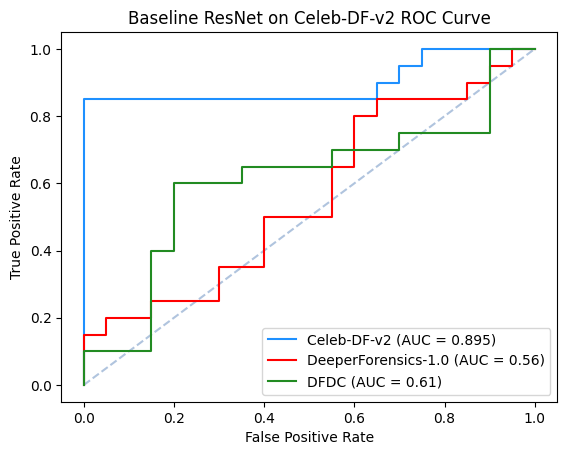

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,3,17
1,DeeperForensics-1.0,7,13,3,17
2,DFDC,15,5,8,12


CPU times: user 1min 1s, sys: 1.33 s, total: 1min 3s
Wall time: 1min 2s


In [15]:
%%time
evaluate_model_on_cross_datasets(
    baseline_resnet_cdf_model,
    datasets,
    model_name="Baseline ResNet on Celeb-DF-v2"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 20.694 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 20.624 seconds

Evaluating on DFDC...
=> Finished in 20.682 seconds



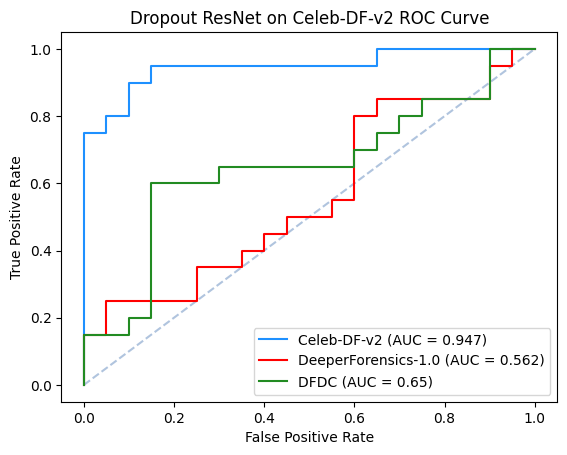

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,18,2,2,18
1,DeeperForensics-1.0,8,12,4,16
2,DFDC,14,6,7,13


CPU times: user 1min 1s, sys: 1.27 s, total: 1min 2s
Wall time: 1min 2s


In [16]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_cdf_model,
    datasets,
    model_name="Dropout ResNet on Celeb-DF-v2"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 1017.542 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 1017.26 seconds

Evaluating on DFDC...
=> Finished in 1008.262 seconds



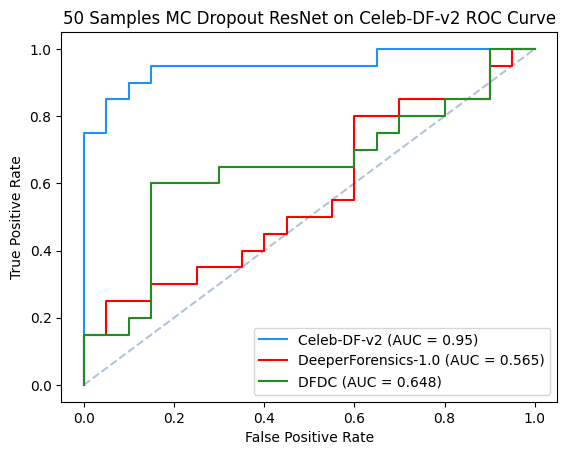

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,18,2,2,18
1,DeeperForensics-1.0,8,12,4,16
2,DFDC,14,6,7,13


CPU times: user 50min 37s, sys: 9.63 s, total: 50min 47s
Wall time: 50min 43s


In [17]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout ResNet on Celeb-DF-v2"

)

#### Trained on DeeperForensics-1.0


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 20.826 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 21.047 seconds

Evaluating on DFDC...
=> Finished in 20.873 seconds



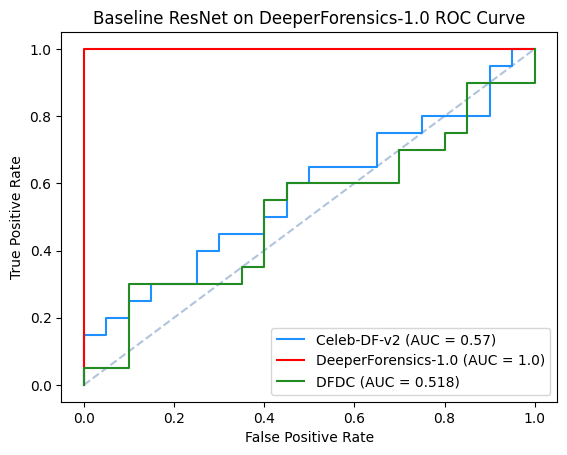

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,2,18,4,16
1,DeeperForensics-1.0,20,0,1,19
2,DFDC,12,8,10,10


CPU times: user 1min 1s, sys: 1.63 s, total: 1min 3s
Wall time: 1min 2s


In [20]:
%%time
evaluate_model_on_cross_datasets(
    baseline_resnet_df_model,
    datasets,
    model_name="Baseline ResNet on DeeperForensics-1.0"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 20.745 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 21.327 seconds

Evaluating on DFDC...
=> Finished in 21.37 seconds



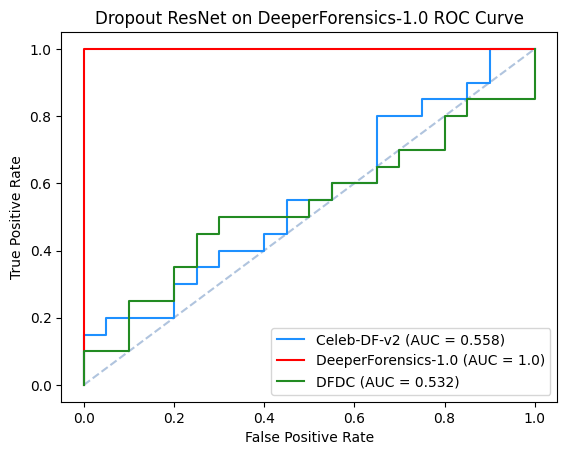

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,7,13,8,12
1,DeeperForensics-1.0,20,0,1,19
2,DFDC,14,6,10,10


CPU times: user 1min 2s, sys: 1.42 s, total: 1min 3s
Wall time: 1min 3s


In [21]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_df_model,
    datasets,
    model_name="Dropout ResNet on DeeperForensics-1.0"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 1009.014 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 1008.35 seconds

Evaluating on DFDC...
=> Finished in 1017.021 seconds



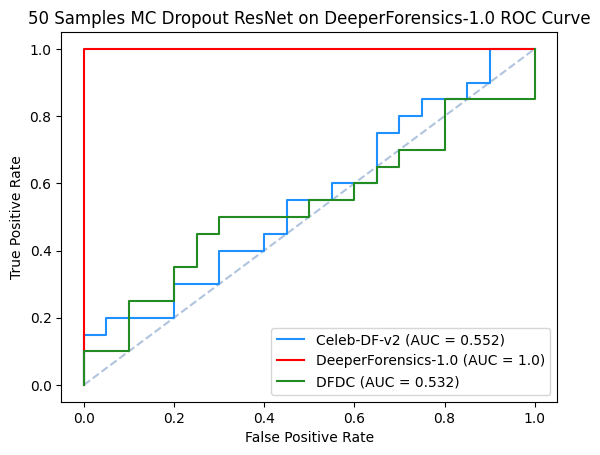

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,7,13,8,12
1,DeeperForensics-1.0,20,0,1,19
2,DFDC,14,6,10,10


CPU times: user 50min 28s, sys: 9.53 s, total: 50min 38s
Wall time: 50min 34s


In [22]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout ResNet on DeeperForensics-1.0"
)

#### Trained on DFDC


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 21.089 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 20.906 seconds

Evaluating on DFDC...
=> Finished in 21.04 seconds



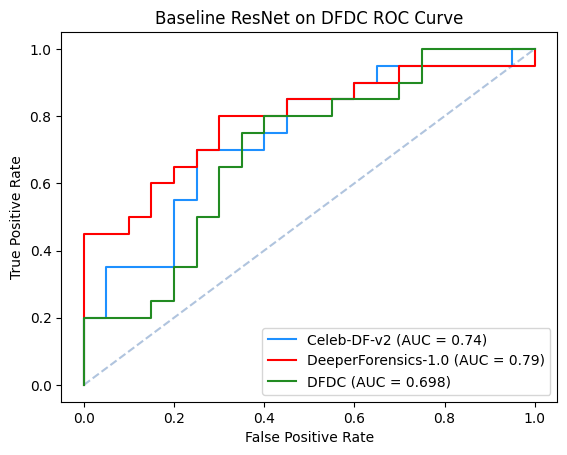

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,19,1,15,5
1,DeeperForensics-1.0,14,6,6,14
2,DFDC,14,6,9,11


CPU times: user 1min 1s, sys: 1.7 s, total: 1min 3s
Wall time: 1min 3s


In [25]:
%%time
evaluate_model_on_cross_datasets(
    baseline_resnet_dfdc_model,
    datasets,
    model_name="Baseline ResNet on DFDC"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 20.836 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 20.73 seconds

Evaluating on DFDC...
=> Finished in 20.76 seconds



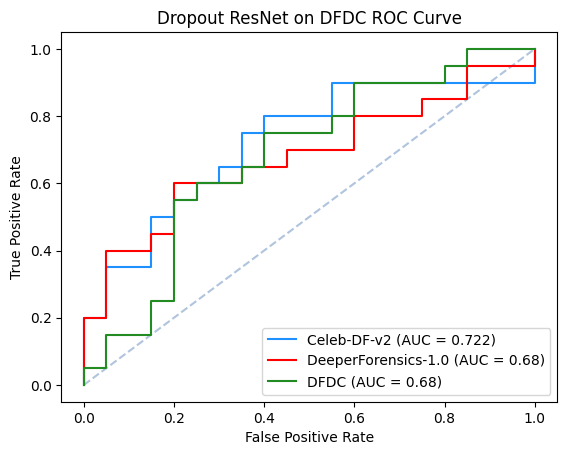

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,10,10
1,DeeperForensics-1.0,10,10,6,14
2,DFDC,12,8,6,14


CPU times: user 1min 1s, sys: 1.42 s, total: 1min 2s
Wall time: 1min 2s


In [26]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_dfdc_model,
    datasets,
    model_name="Dropout ResNet on DFDC"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 1007.702 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 1006.524 seconds

Evaluating on DFDC...
=> Finished in 1005.515 seconds



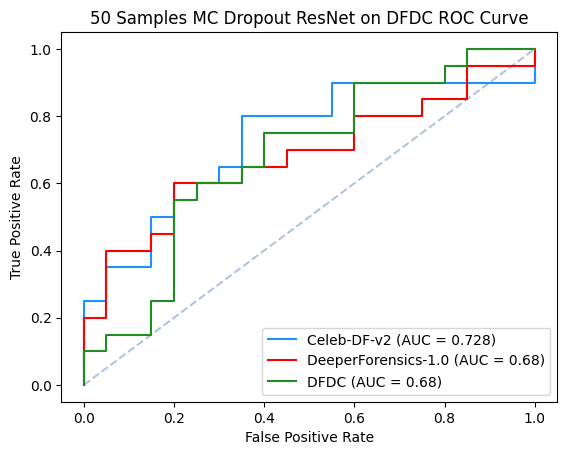

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,10,10
1,DeeperForensics-1.0,10,10,6,14
2,DFDC,12,8,6,14


CPU times: user 50min 14s, sys: 9.43 s, total: 50min 23s
Wall time: 50min 19s


In [27]:
%%time
evaluate_model_on_cross_datasets(
    dropout_resnet_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout ResNet on DFDC"
)